# Nishikawa data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model

corrientes con las que midieron (en unidades de nA)

In [2]:
currents = np.array([1, 2, 3, 5, 10])

potencial de equilibrio que dan y nuestro potencial de corte (150 mV)

In [3]:
eq_pot = 4.739  # V
vcut = 0.15  # V

Usando que la superficie es de 8.04 $\cdot$ 10$^{-6}$ cm$^2$se obtiene puede obtener el diámetro de la partícula (asumiendo una partícula esférica simple)

In [14]:
np.sqrt(0.25 * 8.04e-6 / np.pi)

0.0007998767850296815

que equivale a 7.998768 $\mu$m

Para pasar de la corriene en nA a la C-rate que le correspondería

In [5]:
crate = lambda i: 2.5 * i

Lectura de datos obtenidos a mano (ya que la calidad del gráfico es baja y el software no llega a detectar los colores de las curvas) usando [WebPlotDigitzer](https://apps.automeris.io/wpd/)

In [6]:
dfs = []
for i in currents:
    df = pd.read_csv(f"{i}nA.csv", header=None)
    
    df[0] = np.round(df[0], decimals=2)
    df = df.rename(columns={0: "capacity", 1: f"{i}_nA"})
    
    dfs.append(df)

OUTER JOIN de todas las tablas

In [7]:
nishikawa = dfs[0]
for df in dfs[1:]:
    nishikawa = nishikawa.merge(df, right_on="capacity", left_on="capacity", how="outer")
nishikawa.head()

,capacity,1_nA,2_nA,3_nA,5_nA,10_nA
0,0.00,4.82048,4.81566,4.77590,4.74699,4.67831
1,0.01,4.76623,4.75419,4.73611,4.71563,4.66744
2,0.02,4.74211,4.73488,4.72163,4.70476,4.66259
3,0.03,4.73364,4.72642,4.71316,4.69991,4.66135
4,0.04,4.73000,4.72518,4.71193,4.69867,4.66012


plot:

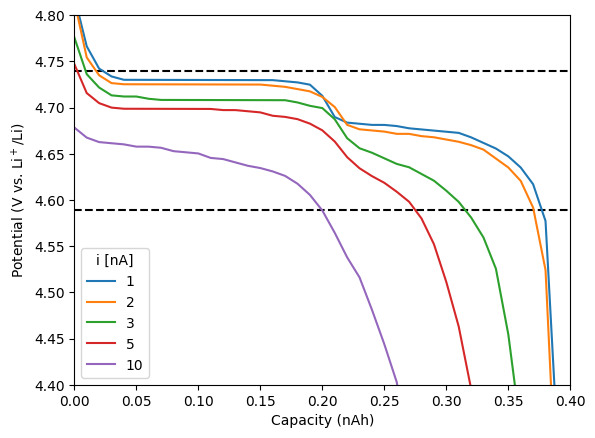

In [8]:
fig, ax = plt.subplots()

# potencial de equilibrio mencionado en el trabajo
ax.axhline(y=eq_pot, color="k", linestyle="--")
# potencial de equilibrio - potencial de corte
ax.axhline(y=eq_pot - vcut, color="k", linestyle="--")
# curvas para cada corriente
for i in currents:
    ax.plot(nishikawa.capacity, nishikawa[f"{i}_nA"], label=f"{i}")

ax.set_xlim((0, 0.4))
ax.set_ylim((4.4, 4.8))
ax.set_xlabel("Capacity (nAh)")
ax.set_ylabel(r"Potential (V vs. Li$^+$/Li)")
ax.legend(title="i [nA]")
plt.show()

Teniendo en cuenta que el potencial medido tiene tres contibuciones:

1. Difusión
2. Transferencia de carga
3. Resistencia

y la última no está considerada en el modelo, podemos restarla si encontramos una relación lineal entre $V$ e $i$ para utilizar la Ley de Ohm y extraer de la pendiente la resistencia.

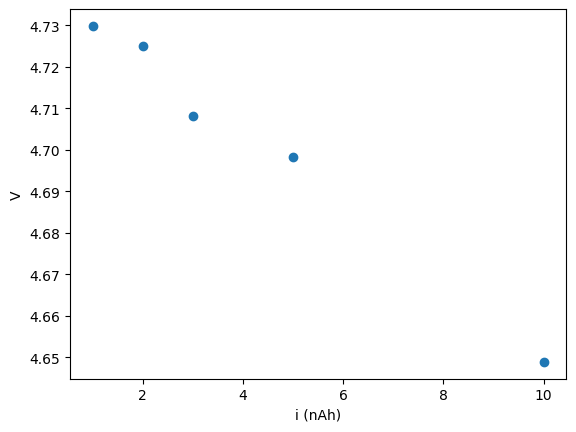

In [9]:
# en la región del plateu veo si se cumple la Ley de Ohm
plateau = np.where((nishikawa.capacity > 0.075) & (nishikawa.capacity < 0.125))[0]

V = np.asarray([np.mean(nishikawa[f"{i}_nA"][plateau]) for i in currents])
    
plt.scatter(currents, V)
plt.xlabel("i (nAh)")
plt.ylabel("V")
plt.show()

Puede ser que esta curva tenga mal el cero (de hecho no pasa por (0, 0)) pero como solo nos interesa la pendiente podemos ajustar una lineal y obtener la resistencia.

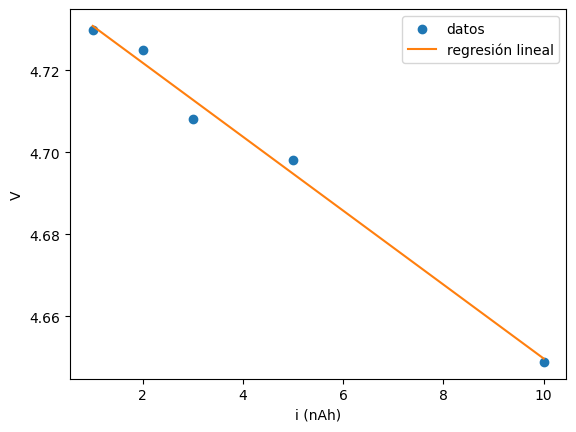

In [10]:
reg = sklearn.linear_model.LinearRegression()
reg.fit(currents.reshape(-1, 1), V)

plt.scatter(currents, V, label="datos")
plt.plot(currents, reg.predict(currents.reshape(-1, 1)), color="tab:orange", label="regresión lineal")
plt.xlabel("i (nAh)")
plt.ylabel("V")
plt.legend()
plt.show()

La pendiente de este ajuste nos da la resistencia en unidades de V / nA. El signo puede ser positivo o negativo según si al electrodo se lo está cargando o descargando.

In [11]:
R = np.abs(reg.coef_[0])
R

0.009019984251968457

Además, resto el potencial de equilibrio para tenerlo en la misma escala que el modelo de maxi.

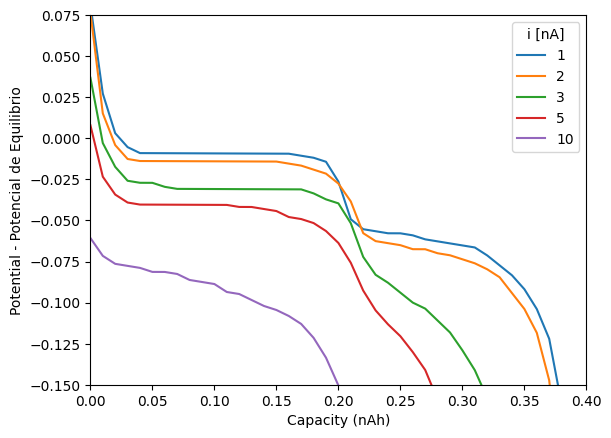

In [12]:
fig, ax = plt.subplots()

for i in currents:
    nishikawa[f"{i}_nA"] = nishikawa[f"{i}_nA"] - eq_pot# + i * R
    ax.plot(nishikawa.capacity, nishikawa[f"{i}_nA"], label=f"{i}")
    ax.set_xlim((0, 0.4))
ax.set_ylim((-0.15, 0.075))
ax.set_xlabel("Capacity (nAh)")
ax.set_ylabel(r"Potential - Potencial de Equilibrio")
ax.legend(title="i [nA]")
plt.show()

Vemos que la curva de 10 nA desaparece cuando restamos la contribución de la resistencia.

Veamos ahora los puntos para los cuales el voltaje alcanza los -150 mV

2.5 0.365
5.0 0.355
7.5 0.315
12.5 0.255
25.0 0.195


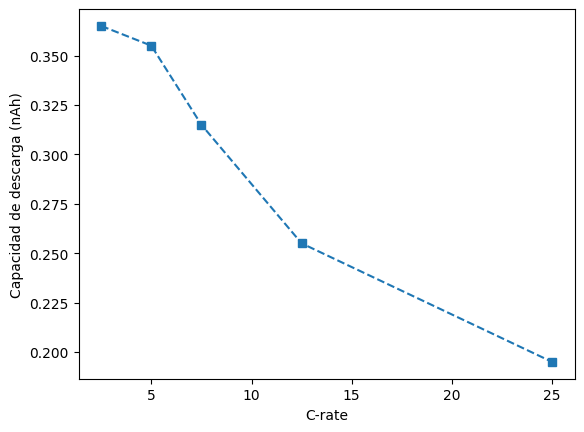

In [13]:
# uno con una recta los valores consecutivos que pasan por -0.15 y tomo el x medio
# obviamente esto puede mejorarse, es sólo una primera aproximación
xmax = []
x = nishikawa.capacity
tols = (0.05, 0.05, 0.02, 0.035, 0.02)
for i, tol in zip(currents, tols):
    y = nishikawa[f"{i}_nA"]
    idxs = np.where((y > -0.15 - tol) & (y < -0.15 + tol))[0]
    
    xprom = (x[idxs[0]] + x[idxs[1]]) / 2
    xmax.append(xprom)
    
    print(crate(i), xprom)
    
plt.plot([crate(i) for i in currents], xmax, marker="s", linestyle="--")
plt.xlabel("C-rate")
plt.ylabel("Capacidad de descarga (nAh)")
plt.show()

Quizás podrían tenerse los datos de nishikawa con mayor precisión y eso mostraría las curvas más suaves pero, como mencioné, el software falla al reconocer las curvas debido a que son muy finas y la calidad de la imagen no es muy buena.